In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/Shared drives/MLL + NLP/Text Classification NLP"

In [ ]:
!pip install transformers

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tqdm import tqdm
tqdm.pandas()

from collections import defaultdict

from torch import nn, optim, functional as F
from torch.utils.data import Dataset, DataLoader

import logging
logging.basicConfig(level=logging.ERROR)

import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [6]:
RANDOM_SEED = 230922
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
# Membaca data
# path = "/content/drive/Shared drives/MLL + NLP/Text Classification NLP/dataset/"
# train = pd.read_csv(path+"train.csv",encoding="Latin-1")
# test = pd.read_csv(path+"test.csv",encoding="Latin-1")
# dev = pd.read_csv(path+"dev.csv",encoding="Latin-1")

train = pd.read_csv("train.csv",encoding="Latin-1")
test = pd.read_csv("test.csv",encoding="Latin-1")
dev = pd.read_csv("dev.csv",encoding="Latin-1")

In [8]:
train = train.drop(columns=['Unnamed: 0'])
train.sample(5)

,text_a,label
2938,airasia kalo refund sih februari uang gw gak masuk masuk,no
17168,alasan untk tipsen takut kena corona,no
17321,tes,no
6204,yaqoob azeem aur 645 dyeay jain ge magr main bina advertiese ya patient ko bina bataye us p test kya jaye ga mar gia to corona ka name day kar dafan yehaan papers sign karwa k paisay test kya jaye ga,no
8154,anggota polsek tekung patroli rangka antisipasi 3c himbauan physical distancing masyarakat rumah jaga jarak memakai masker pemutus covid 19,yes


In [9]:
print("Train shape\t:",train.shape)
print("Test shape\t:",test.shape)
print("Dev shape\t:",dev.shape)

Train shape	: (21601, 2)
Test shape	: (2800, 2)
Dev shape	: (2800, 2)


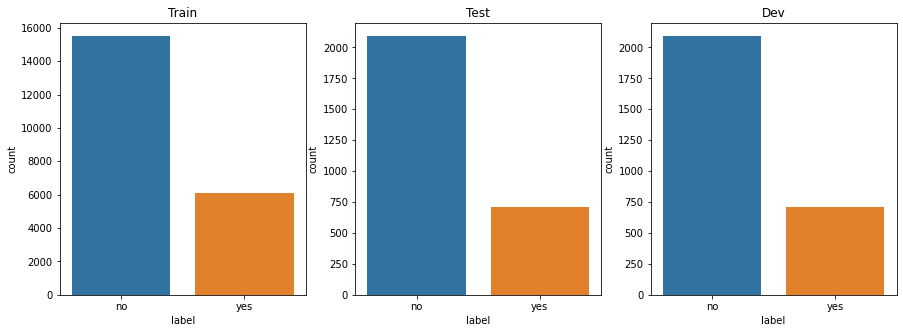

In [ ]:
# Melihat distribusi kelas train, dev, test
plt.subplots(1,3,figsize=(15,5))
plt.subplot(1,3,1)
sns.countplot(train['label'])
plt.title("Train")
plt.subplot(1,3,2)
sns.countplot(test['label'])
plt.title("Test")
plt.subplot(1,3,3)
sns.countplot(dev['label'])
plt.title("Dev")
plt.show()

In [ ]:
# change every label on train, dev, and test into encoded 0 and 1
train['label'] = train['label'].replace({'no':0,'yes':1})
test['label'] = test['label'].replace({'no':0,'yes':1})
dev['label'] = dev['label'].replace({'no':0,'yes':1})

train.sample(1)

,text_a,label
4957,commuterline admin mohon jam krl notmal aja karna ga orang dikasih wfh kantornya jam krl normal malam ttp pakai aturan distancing dlm krl pengguna krl yg bnyk kerja malam,0


## Load Tokenizer

In [10]:
MODEL_NAME = "indolem/indobertweet-base-uncased"

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)

In [ ]:
#testing tokenizer
sample_txt = train.iloc[15678]['text_a']

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f"Original  : {sample_txt}")
print(f"Token     : {tokens}")
print(f"Token IDs : {token_ids}")

Original  : nda diskon promo potongan ukt gitu mendikbuddicarimahasiswa
Token     : ['nda', 'diskon', 'promo', 'potongan', 'ukt', 'gitu', 'mendikbud', '##dic', '##arim', '##ahasiswa']
Token IDs : [11689, 25065, 21949, 9041, 10009, 14244, 9252, 30125, 29666, 25391]


In [12]:
# Membuat fungsi untuk mengencode text
def encode_sentence(sent, tokenizer, max_len):
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        truncation = True,
                        add_special_tokens = True, 
                        max_length = max_len,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_token_type_ids = False, # we dont need that bcs its not sequence cls
                        return_tensors = 'pt',  # return pytorch type  
                   )
    
    return encoded_dict

In [17]:
# testing encoder
example_encoded = encode_sentence(train.iloc[15678]['text_a'], tokenizer, 64) # 512 is the max size of normal BERT, using 64 for testing

In [18]:
# input_ids
print(f"== INPUT IDS ==")
print(len(example_encoded['input_ids'][0]))
print(example_encoded['input_ids'][0])

print()

# attention mask
print(f"== ATTENTION MASK ==")
print(len(example_encoded['attention_mask'][0]))
print(example_encoded['attention_mask'][0])

# convert back to tokens
print()
print(tokenizer.convert_ids_to_tokens(example_encoded['input_ids'][0]))

== INPUT IDS ==
64
tensor([    3, 11689, 25065, 21949,  9041, 10009, 14244,  9252, 30125, 29666,
        25391,     4,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])

== ATTENTION MASK ==
64
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

['[CLS]', 'nda', 'diskon', 'promo', 'potongan', 'ukt', 'gitu', 'mendikbud', '##dic', '##arim', '##ahasiswa', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

In [13]:
MAXIMUM_LEN_SENTENCE = 256 # using 256 for every text's instances in order to get quicker inference

## Create Dataset class & dataloader

In [41]:
# create TextClassificationDataset class and create_dataloader function
class TextClassificationDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.text = df.text_a
        self.targets = df.label
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        # print(type(self.text[item]))
        text = str(self.text[item])
        target = self.targets[item]

        encoding = encode_sentence(text, self.tokenizer, self.max_len)

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

def create_dataloader(df, tokenizer, max_len, batch_size):
    ds = TextClassificationDataset(
        df = df,
        tokenizer = tokenizer,
        max_len = max_len
    )

    return DataLoader(
        ds,
        batch_size = batch_size,
        num_workers = 2
    )

In [42]:
# implement create_dataloader to train, dev, and test
BATCH_SIZE = 32

train_data_loader = create_dataloader(train, tokenizer, MAXIMUM_LEN_SENTENCE, BATCH_SIZE)
dev_data_loader = create_dataloader(dev, tokenizer, MAXIMUM_LEN_SENTENCE, BATCH_SIZE)
test_data_loader = create_dataloader(test, tokenizer, MAXIMUM_LEN_SENTENCE, BATCH_SIZE)

In [43]:
# print inside of data loader
data = next(iter(train_data_loader))
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32])


## Create model

In [26]:
# create model class
class TextClassification(nn.Module):
    def __init__(self, n_classes):
        super(TextClassification, self).__init__()
        self.bert = BertModel.from_pretrained(
            MODEL_NAME,
            return_dict = False
        )
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask
        )

        output = self.drop(pooled_output)
        return self.out(output)

In [27]:
# put model into cuda
model = TextClassification(2) # 2 classes
model = model.to(device)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at indolem/indobertweet-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Training phase

In [28]:
EPOCHS = 3

In [29]:
# create optimizer and loss function

# create 2 optimizers for experiments
optimizer1 = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer1,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [30]:
# create train function
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(output, dim=1)
        loss = loss_fn(output, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double()/n_examples, np.mean(losses)

In [31]:
# creat3 evaluate function
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in tqdm(data_loader):
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)
      texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return texts, predictions, prediction_probs, real_values

## Experiment 1: lr=2e-5

In [ ]:
# train model
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer1,
        device,
        scheduler,
        len(train)
    )

    print(f'Train      acc {train_acc} loss {train_loss}')

    val_acc, val_loss = eval_model(
        model,
        dev_data_loader,
        loss_fn,
        device,
        len(dev)
    )

    print(f'Validation acc {val_acc} loss {val_loss}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy: # save the best model for prediction
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/3
----------


100%|██████████| 676/676 [15:06<00:00,  1.34s/it]


Train      acc 0.8835239109300494 loss 0.2825127671012578


100%|██████████| 88/88 [00:46<00:00,  1.90it/s]


Validation acc 0.8914285714285715 loss 0.32263876080766996

Epoch 2/3
----------


100%|██████████| 676/676 [15:05<00:00,  1.34s/it]


Train      acc 0.9405583074857645 loss 0.1619579757279792


100%|██████████| 88/88 [00:46<00:00,  1.89it/s]


Validation acc 0.8992857142857142 loss 0.3815448555079373

Epoch 3/3
----------


100%|██████████| 676/676 [15:05<00:00,  1.34s/it]


Train      acc 0.9571779084301653 loss 0.12674594687118151


100%|██████████| 88/88 [00:46<00:00,  1.89it/s]

Validation acc 0.8639285714285714 loss 0.4661536989733577

CPU times: user 47min 9s, sys: 15.6 s, total: 47min 25s
Wall time: 47min 39s


In [ ]:
history['val_acc']

[tensor(0.8914, device='cuda:0', dtype=torch.float64),
 tensor(0.8993, device='cuda:0', dtype=torch.float64),
 tensor(0.8639, device='cuda:0', dtype=torch.float64)]

(0.0, 1.0)

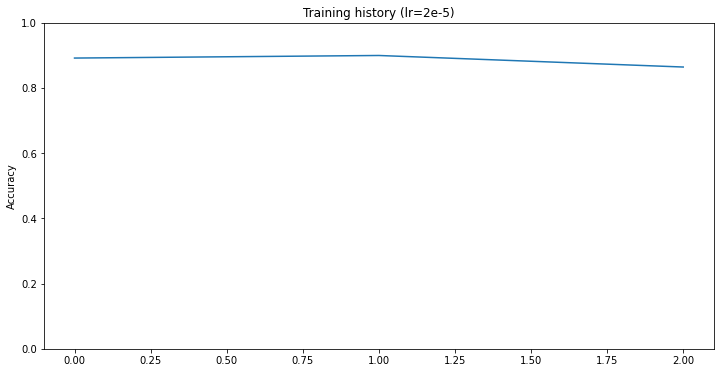

In [ ]:
history_val_acc = [0.8914, 0.8993, 0.8639]

# plot the history
plt.figure(figsize=(12, 6))
plt.plot(history_val_acc, label='validation accuracy')
plt.title('Training history (lr=2e-5)')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

In [ ]:
y_text, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

100%|██████████| 88/88 [00:47<00:00,  1.83it/s]


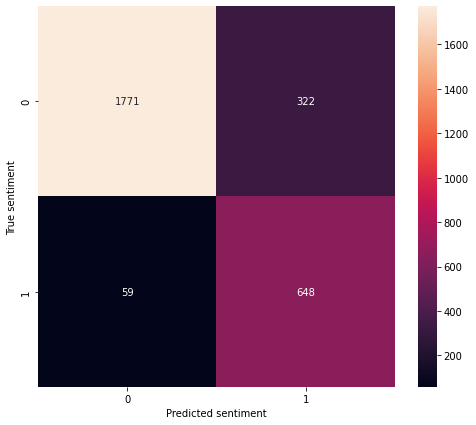

In [ ]:
# print confusion_matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['no','yes'], columns=['no','yes'])
hmap = sns.heatmap(cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels())
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels())
plt.ylabel('True sentiment')
plt.xlabel('Predicted sentiment')
plt.gcf().set_size_inches(8, 7)

In [ ]:
print(classification_report(y_test, y_pred, target_names=['no','yes']))

              precision    recall  f1-score   support

          no       0.97      0.85      0.90      2093
         yes       0.67      0.92      0.77       707

    accuracy                           0.86      2800
   macro avg       0.82      0.88      0.84      2800
weighted avg       0.89      0.86      0.87      2800



#### Predict

In [ ]:
ex_text = train.iloc[0]['text_a']
print(ex_text)
print(f'label: {train.iloc[0]["label"]}')

betewe buka twitter cuman ngetweet liat home berita corona panik kepikiran ndamau buka2 home yg aware aja i ll stay at home nda rumah kalo nda penting2 banget
label: 0


In [ ]:
encoded_text = encode_sentence(ex_text, tokenizer, MAXIMUM_LEN_SENTENCE)

In [ ]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Raw Text            : {ex_text}')
class_names = [0,1]
print(f'prediction label    : {class_names[prediction]}')

Raw Text            : betewe buka twitter cuman ngetweet liat home berita corona panik kepikiran ndamau buka2 home yg aware aja i ll stay at home nda rumah kalo nda penting2 banget
prediction label    : 0


## Experiment 2: lr=5e-4

In [44]:
optimizer2 = AdamW(model.parameters(), lr=5e-4, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer2,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [45]:
# train model
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer2,
        device,
        scheduler,
        len(train)
    )

    print(f'Train      acc {train_acc} loss {train_loss}')

    val_acc, val_loss = eval_model(
        model,
        dev_data_loader,
        loss_fn,
        device,
        len(dev)
    )

    print(f'Validation acc {val_acc} loss {val_loss}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy: # save the best model for prediction
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/3
----------


100%|██████████| 676/676 [14:31<00:00,  1.29s/it]


Train      acc 0.6828850516179806 loss 0.6925650271173764


100%|██████████| 88/88 [00:40<00:00,  2.18it/s]


Validation acc 0.7475 loss 0.5670785768465563

Epoch 2/3
----------


100%|██████████| 676/676 [14:29<00:00,  1.29s/it]


Train      acc 0.6991342993379935 loss 0.61827886865072


100%|██████████| 88/88 [00:40<00:00,  2.18it/s]


Validation acc 0.7475 loss 0.5780899307944558

Epoch 3/3
----------


100%|██████████| 676/676 [14:27<00:00,  1.28s/it]


Train      acc 0.7146891347622795 loss 0.6044487780808697


100%|██████████| 88/88 [00:40<00:00,  2.18it/s]

Validation acc 0.7475 loss 0.5671036571941592

CPU times: user 44min 58s, sys: 13.5 s, total: 45min 12s
Wall time: 45min 31s


In [46]:
history['val_acc']

[tensor(0.7475, device='cuda:0', dtype=torch.float64),
 tensor(0.7475, device='cuda:0', dtype=torch.float64),
 tensor(0.7475, device='cuda:0', dtype=torch.float64)]

(0.0, 1.0)

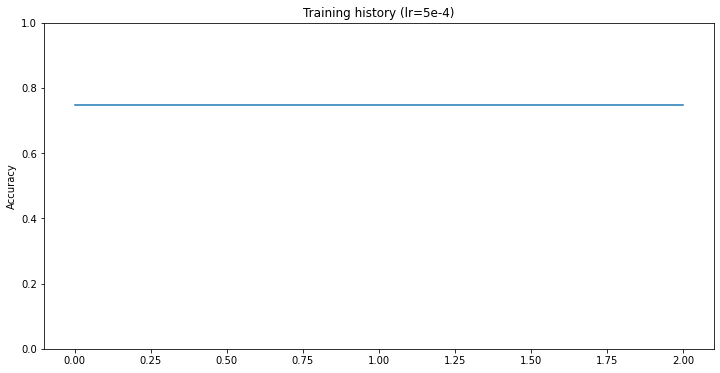

In [47]:
history_val_acc = [0.7475, 0.7475, 0.7475]

# plot the history
plt.figure(figsize=(12, 6))
plt.plot(history_val_acc, label='validation accuracy')
plt.title('Training history (lr=5e-4)')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

In [48]:
y_text, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

100%|██████████| 88/88 [00:41<00:00,  2.14it/s]


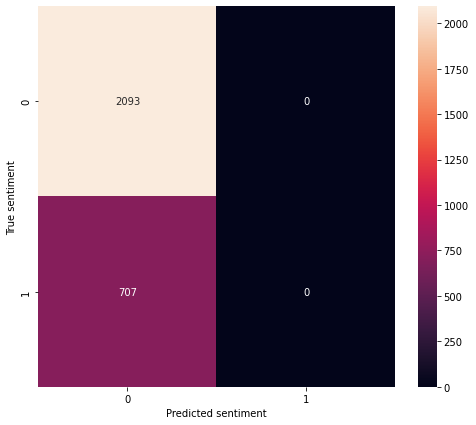

In [49]:
# print confusion_matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['no','yes'], columns=['no','yes'])
hmap = sns.heatmap(cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels())
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels())
plt.ylabel('True sentiment')
plt.xlabel('Predicted sentiment')
plt.gcf().set_size_inches(8, 7)

In [50]:
print(classification_report(y_test, y_pred, target_names=['no','yes']))

              precision    recall  f1-score   support

          no       0.75      1.00      0.86      2093
         yes       0.00      0.00      0.00       707

    accuracy                           0.75      2800
   macro avg       0.37      0.50      0.43      2800
weighted avg       0.56      0.75      0.64      2800



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Predict

In [51]:
ex_text = train.iloc[1]['text_a']
print(ex_text)
print(f'label: {train.iloc[1]["label"]}')

mas piyuuu mugo2 corona tuh mulut tersumpal ma corona
label: 0


In [52]:
encoded_text = encode_sentence(ex_text, tokenizer, MAXIMUM_LEN_SENTENCE)

In [53]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Raw Text            : {ex_text}')
class_names = [0,1]
print(f'prediction label    : {class_names[prediction]}')

Raw Text            : mas piyuuu mugo2 corona tuh mulut tersumpal ma corona
prediction label    : 0
